In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def acceleration(m, *forces):
    ''' Return acceleration given a list of forces and mass. '''
    
    F_net = sum(forces)
    return F_net / m    

In [3]:
def F_g(m, y, R=6.371e6, M=5.972e24, G=6.67408e-11):
    ''' Return gaviational force given mass and elevation '''
    
    return -(m * M * G) / (y + R)**2

In [4]:
class Stage:
    ''' Class for handling stage calculations. '''
    
    def __init__(self, name=None, empty_mass=0, fuel_mass=0, thrust=0, exhaust_velocity=0):
        
        self.name = name
        
        self.thrust = thrust
        self.exhaust_velocity = exhaust_velocity
        
        self.fuel_mass = fuel_mass
        self.empty_mass = empty_mass
        
    def burn(self, dt):
        ''' Burn stage for dt seconds, return impulse. '''
        
        if not self.fuel_empty:
            self.fuel_mass -= (self.thrust / self.exhaust_velocity) * dt
    
    @property
    def fuel_empty(self):
        ''' Return true if out of fuel. '''
        
        return not self.fuel_mass > 0
            
    @property
    def mass(self):
        ''' Return combined fuel/empty mass. '''
        
        return self.fuel_mass + self.empty_mass

In [ ]:
def euler(t_list, x_list, v_list, a_list, m_list, acceleration, stopping_condtion):
    ''' Run trajectory euler simulation according to a given acceleration function until set stopping condition. '''
    
    t = t_list[-1]
    x = x_list[-1]
    v = v_list[-1]
    a = a_list[-1]
    m = m_list[-1]
    
    while not stopping_condtion():
        a = acceleration()
        
        t += dt
        x += v * dt
        v += a * dt
        
        t_list.append(t)
        x_list.append(x)
        v_list.append(v)
        a_list.append(a)
        m_list.append(m)
        
    return t_list, x_list, v_list, a_list, m_list
        

In [12]:
class Rocket:
    
    def __init__(self, stages, stage_delay=3.5):
        
        self.stages = stages
        self.stage_delay = stage_delay
    
    @property
    def mass(self):
        ''' Return sum of remaining mass from all stages. '''
        
        return sum(s.mass for s in self.stages)
    
    def add_stage(self, stage):
        self.stages.append(stage)
        
    def launch(self, dt, verbose=False):
        
        t = 0
        x = 0
        v = 0
        a = 0
        m = self.mass
        
        t_list = [t]
        x_list = [x]
        v_list = [v]
        a_list = [a]
        m_list = [m]
        
        for stage in self.stages:
            
            if verbose: print('Firing %s. t=%.0f, x=%.0f' % (stage.name, t, x))
            
            while not stage.fuel_empty:
                a = acceleration(self.mass, stage.thrust, F_g(m=self.mass, y=x))
                
                t += dt
                x += v * dt
                v += a * dt
                
                stage.burn(dt)
                
                t_list.append(t)
                x_list.append(x)
                v_list.append(v)
                a_list.append(a)
                m_list.append(self.mass)
            
            if verbose: print('%s burn complete. t=%.0f, x=%.0f' % (stage.name, t, x))
            
            if stage.name != 'Payload':
                pause = t + 3
                while t < pause:
                    a = acceleration(self.mass, F_g(m=self.mass, y=x))

                    t += dt
                    x += v * dt
                    v += a * dt

                    t_list.append(t)
                    x_list.append(x)
                    v_list.append(v)
                    a_list.append(a)
                    m_list.append(self.mass)     
            elif stage.name == 'Payload':
                if verbose: print('Payload in free-fall.')
                
                while v > 0:
                    a = acceleration(self.mass, F_g(m=self.mass, y=x))

                    t += dt
                    x += v * dt
                    v += a * dt

                    t_list.append(t)
                    x_list.append(x)
                    v_list.append(v)
                    a_list.append(a)
                    m_list.append(self.mass)
                    
                if verbose: print('Payload stopped. x=%.0f' % x)
            
        return t_list, x_list, v_list, a_list, m_list

Firing Stage I. t=0, x=0
Stage I burn complete. t=165, x=87753
Firing Stage II. t=168, x=93181
Stage II burn complete. t=535, x=697285
Firing Stage III. t=538, x=703513
Stage III burn complete. t=985, x=1218604
Firing Payload. t=988, x=1219852
Payload burn complete. t=988, x=1219852
Payload in free-fall.
Payload stopped. x=1231762


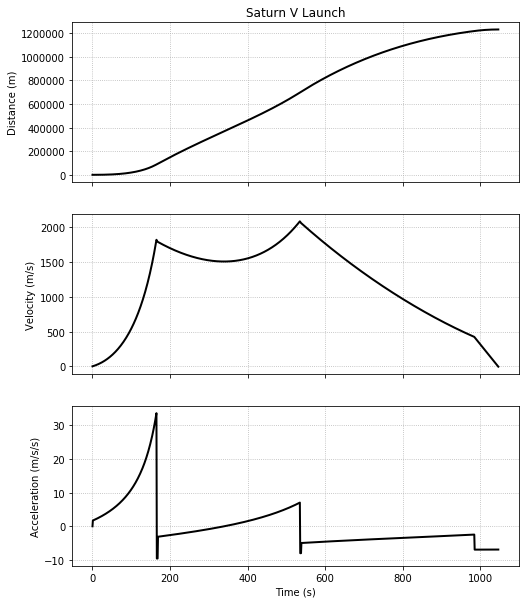

In [30]:
payload   = Stage(name='Payload', 
                  empty_mass=52e3
                 )

stage_I   = Stage(name='Stage I', 
                  empty_mass=131e3,
                  fuel_mass=2300e3-131e3,
                  thrust=34e6,
                  exhaust_velocity=2580
                 )

stage_II  = Stage(name='Stage II', 
                  empty_mass=36e3,
                  fuel_mass=480e3-36e3,
                  thrust=5e6,
                  exhaust_velocity=4130
                 )

stage_III = Stage(name='Stage III', 
                  empty_mass=11e3,
                  fuel_mass=119e3-11e3,
                  thrust=1e6,
                  exhaust_velocity=4130
                 )

# Fill stages in order of burn!
stages = [stage_I, stage_II, stage_III, payload]

rocket = Rocket(stages)

t, x, v, a, m = rocket.launch(dt=1, verbose=True)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)

fig.set_size_inches(8, 10)

ax1.plot(t, x, c='black', linewidth=2)
ax2.plot(t, v, c='black', linewidth=2)
ax3.plot(t, a, c='black', linewidth=2)

ax1.set_title('Saturn V Launch')

ax1.set_ylabel('Distance (m)')
ax2.set_ylabel('Velocity (m/s)')
ax3.set_ylabel('Acceleration (m/s/s)')

ax3.set_xlabel('Time (s)')

ax1.grid(which='both', linestyle=':')
ax2.grid(which='both', linestyle=':')
ax3.grid(which='both', linestyle=':')

fig.show()

Things are really getting down to the wire here, so lets do this the quick way. Rather than building up abstraction, classes, functions, etc. I am going to write this problem procedurally. It will look much more like a MATLAB script, probably be a bit less clear, be far less extensible, *but it will be fast to write*. 

## Exercise 1

Your mission is to build a computational model of a Saturn V rocket that indicates the effect of burning the fuel in all three rocket stages. Remember to include detailed comments in your simulation program. Relevant data for the sates of a Saturn V rocket is proved in Table 1. More detailed infromation on the Saturn V rocket can be foudn on the [Saturn V Wikipedia page](https://en.wikipedia.org/wiki/Saturn_V). Launch your rocket from rest in a direction that points radially outward from the center of the Earth (straight up), and maintain this oreintation throughout the rocket's motion. Provde a detailed assesment of the accuracy of your rocket model. By now, you should be able to demonstarte in detail how you would determine a sufficiently small value of $\Delta t$ to ensure an accurate solution. Produce graphs of the altitude, velocity, and acceleration of the rocket as a function of time from the instant the rocket was launched until the instant the third stage has been jettisoned. **NOTE:** build the model such that the time bettween prior stage jettisoning and current stage ignition is 3--4 seconds.

1. Build rocket model for three stages.
2. Determine suffient $\Delta t$
3. Plot t, x, v, and a from T=0 to the release of Stage III (i.e. no coasting)

|  Stage    | T (N) | $v_e$ (m/s) | empty mass (kg) | fully fueled mass (kg) |
|  :---:   | ----: | ----:       | ----:           | ----:                 |
| Stage I   | 34,000,000 | 2,580 | 131,000 | 2,300,000 |
| Stage II  |  5,000,000 | 4,130 |  36,000 |   480,000 |
| Stage III |  1,000,000 | 4,130 |  11,000 |   119,000 |
| Payload   |            |       |         |    52,000 |

## Exercise 2

The average distance from Earth to teh Moon is 384,403 km. Use your model to determine what happens to the rocket after all the fuel in the three stages has been burned, adn the stages have been jettisoned. Does you rocket make it to a distance of 384,403 km from Earth? Provide a detailed description of the behavior of your model.

## Exercise 3

IF you did not make it to the Moon (this is a hint for the result of Exercise 2), can you account for what's missing from the model, even though in the model you have used the correct Saturn V parameters provided by NASA? The answer to this question may require some significant investigation/thinking on your part. Again, provide a detailed answer/analysis to this question.

## Exercise 4

**WARNING: DO NOT read the following until you have completed Exercise 3; otherwise, it may short-circuit your educational experience.**

Starting from the rocket's parking orbit (third stage not completely empty---hopefully you have discovered what the parking orbit is in researching your answer to Exercise 3), produce a detailed *pseudocode* for modeling the tran-lunar injection maneuver. Include the gravitational influence of the Moon in your pseudocode, (i.e. the Earth, the Moon, and the rocket are all interacting via the gravitational force). You are not expect to produce a working code for the trans--lunar injection, but you could try if you have time and sufficent interest. *HINT: IF you decide to try to produce the code for the trans lunar injection, keep it constrianed to a 2D problem*.